# Pattern Analysis
https://web.ist.utl.pt/rmch/dash/guides/AssociationRuleMining%20in%20Python.html

Association Pattern Analysis

- What are the aisles most purchased together?
- Which aisles are most reordered together?
- Which aisles are most ordered isolately?

ARM Resources
- https://www.kaggle.com/code/datatheque/association-rules-mining-market-basket-analysis/notebook
- https://comum.rcaap.pt/bitstream/10400.26/37552/1/Tese_JoanaOliveira.pdf

# File and libraries

In [10]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [11]:
%run "scripts/dslabs_functions.py"

# data functions

In [12]:
%run "scripts/data_functions.py"

data_functions loaded


# Load

In [13]:
test_data=True
# test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    # data=pd.read_csv(filepath)
    data=pd.read_csv(r'data\instacart_pre_proc_sample.csv')

    # Apply the sampling to each group 0.5%
    sample=0.5
    data = sample_user_orders(data, fraction=sample)


else:
    # data=pd.read_csv(r'data\instacart_pre_proc.csv')
    
    data=pd.read_csv(r'data\instacart_pre_proc_sample.csv')

    # Apply the sampling to each group 1%
    # sample=0.05
    # data = sample_user_orders(data, fraction=sample)



data=enrich_instacart_df(data)



data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620622 entries, 0 to 1620621
Data columns (total 25 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   order_id                 1620622 non-null  int64  
 1   product_id               1620622 non-null  int64  
 2   add_to_cart_order        1620622 non-null  int64  
 3   reordered                1620622 non-null  int64  
 4   user_id                  1620622 non-null  int64  
 5   order_number             1620622 non-null  int64  
 6   order_dow                1620622 non-null  int64  
 7   order_hour_of_day        1620622 non-null  int64  
 8   days_since_prior_order   1517754 non-null  float64
 9   order_time_of_day        1620622 non-null  object 
 10  is_weekend               1620622 non-null  int64  
 11  is_peak_time_of_day      1620622 non-null  int64  
 12  weeks_since_prior_order  1517754 non-null  float64
 13  order_time_of_day_enc    1620622 non-null 

In [ ]:
data.to_csv(r'data\instacart_pre_proc_sample_50_sampled.csv', index=False)

## drop nulls

- this will drop all first buying orders from the dataframe

In [14]:
# drop any null values
data=data.dropna()

# department correlation visualization

In [15]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


department_df = data.pivot_table(index='order_id', columns='department', values='product_id', aggfunc='count', fill_value=0)
# Convert the DataFrame to boolean type
department_df = department_df.astype(bool)


c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


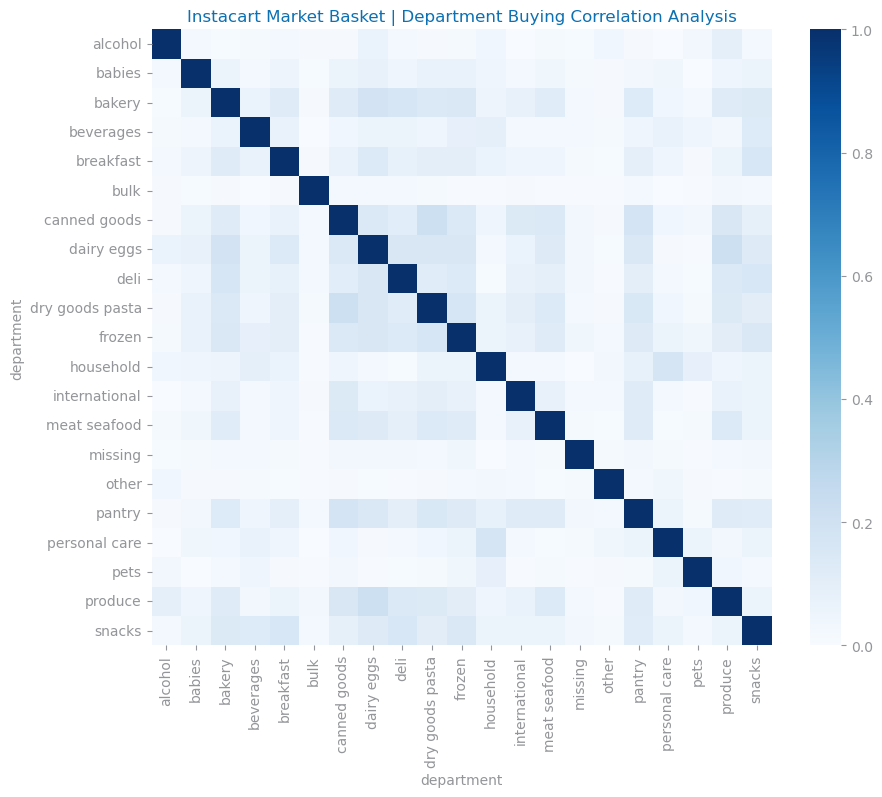

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_mtx = department_df.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=False, cmap="Blues", vmin=0, vmax=1)
plt.title(f'{file_tag} | Department Buying Correlation Analysis')
plt.savefig(f"images/{file_tag}_correlation_analysis.png")
plt.show()

In [ ]:
find_patterns(department_df, mine_rules=True, min_patterns=10, min_length=2, max_pvalue=0.05, min_confidence=0.6, min_lift=1.4)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Finding patterns with min sup 0.109419
Finding patterns with min sup 0.098477
Finding patterns with min sup 0.088629
Finding patterns with min sup 0.079766
Number of found patterns: 19


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
8,"(bakery, beverages)",(snacks),0.085019,0.610531,1.414495,"bakery, beverages, snacks",3,0.0
16,"(bakery, frozen)",(snacks),0.081459,0.620133,1.436742,"bakery, frozen, snacks",3,0.0
36,"(bakery, pantry)","(produce, dairy eggs)",0.095327,0.776635,1.406346,"bakery, pantry, produce, dairy eggs",4,0.0
52,"(snacks, canned goods)","(produce, dairy eggs)",0.085371,0.783542,1.418852,"produce, dairy eggs, snacks, canned goods",4,0.0
64,"(frozen, canned goods)","(produce, dairy eggs)",0.082708,0.783750,1.419229,"frozen, produce, dairy eggs, canned goods",4,0.0
82,"(pantry, canned goods)","(produce, dairy eggs)",0.084773,0.781198,1.414609,"pantry, produce, dairy eggs, canned goods",4,0.0
88,(breakfast),(snacks),0.099040,0.608926,1.410778,"breakfast, snacks",2,0.0
90,"(breakfast, dairy eggs)",(snacks),0.084993,0.632044,1.464338,"snacks, breakfast, dairy eggs",3,0.0
94,"(breakfast, produce)",(snacks),0.082044,0.626261,1.450939,"breakfast, produce, snacks",3,0.0
105,"(pantry, deli)","(produce, dairy eggs)",0.081891,0.789575,1.429777,"pantry, deli, dairy eggs, produce",4,0.0


In [18]:
find_patterns(department_df, mine_rules=True, min_patterns=20, min_length=2, max_pvalue=0.10, min_confidence=0.6, min_lift=1.2)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Number of found patterns: 28


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
0,(bakery),(dairy eggs),0.224573,0.821701,1.209517,"bakery, dairy eggs",2,0.0
8,"(bakery, produce)",(dairy eggs),0.194400,0.851887,1.253950,"bakery, produce, dairy eggs",3,0.0
10,(bakery),"(produce, dairy eggs)",0.194400,0.711300,1.288036,"bakery, produce, dairy eggs",3,0.0
16,"(bakery, snacks)",(dairy eggs),0.127293,0.863294,1.270741,"bakery, snacks, dairy eggs",3,0.0
22,"(produce, meat seafood)",(dairy eggs),0.130156,0.830065,1.221828,"produce, meat seafood, dairy eggs",3,0.0
24,"(meat seafood, dairy eggs)",(produce),0.130156,0.903754,1.205715,"meat seafood, dairy eggs, produce",3,0.0
26,(meat seafood),"(produce, dairy eggs)",0.130156,0.728242,1.318715,"meat seafood, dairy eggs, produce",3,0.0
34,"(produce, beverages, snacks)",(dairy eggs),0.149031,0.832987,1.226129,"produce, beverages, snacks, dairy eggs",4,0.0
45,"(produce, canned goods)",(dairy eggs),0.153999,0.828758,1.219905,"produce, dairy eggs, canned goods",3,0.0
46,"(dairy eggs, canned goods)",(produce),0.153999,0.901586,1.202824,"produce, dairy eggs, canned goods",3,0.0


# aisle Order ID Mining
- group order ids and dummify aisle

In [19]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


aisle_df = data.pivot_table(index='order_id', columns='aisle', values='product_id', aggfunc='count', fill_value=0)
# Convert the DataFrame to boolean type
aisle_df = aisle_df.astype(bool)


## Top Aisles Association Pattern Mining

In [20]:
find_patterns(aisle_df, mine_rules=True, min_patterns=10, min_length=2, max_pvalue=0.1, min_confidence=0.6, min_lift=1.4)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Finding patterns with min sup 0.109419
Finding patterns with min sup 0.098477
Finding patterns with min sup 0.088629
Number of found patterns: 10


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
1,(packaged vegetables fruits),(fresh vegetables),0.233758,0.637736,1.440961,"fresh vegetables, packaged vegetables fruits",2,0.0
2,"(fresh vegetables, packaged vegetables fruits)",(fresh fruits),0.186177,0.796454,1.423759,"fresh vegetables, packaged vegetables fruits, ...",3,0.0
4,"(packaged vegetables fruits, fresh fruits)",(fresh vegetables),0.186177,0.688375,1.555380,"fresh vegetables, packaged vegetables fruits, ...",3,0.0
8,"(yogurt, fresh vegetables)",(fresh fruits),0.117636,0.816635,1.459835,"yogurt, fresh vegetables, fresh fruits",3,0.0
9,"(yogurt, fresh fruits)",(fresh vegetables),0.117636,0.622303,1.406092,"yogurt, fresh vegetables, fresh fruits",3,0.0
14,"(yogurt, packaged vegetables fruits)",(fresh fruits),0.105754,0.827341,1.478972,"yogurt, packaged vegetables fruits, fresh fruits",3,0.0
21,"(fresh fruits, packaged cheese)",(fresh vegetables),0.104898,0.676287,1.528067,"fresh vegetables, fresh fruits, packaged cheese",3,0.0
25,"(packaged vegetables fruits, packaged cheese)",(fresh fruits),0.090412,0.794595,1.420435,"packaged vegetables fruits, fresh fruits, pack...",3,0.0
32,"(fresh vegetables, milk)",(fresh fruits),0.099923,0.795443,1.421950,"fresh vegetables, milk, fresh fruits",3,0.0
34,"(milk, packaged vegetables fruits)",(fresh fruits),0.089051,0.811475,1.450610,"milk, packaged vegetables fruits, fresh fruits",3,0.0


In [21]:
find_patterns(aisle_df,mine_rules = False, min_patterns = 5, min_length = 3, max_pvalue = 0.2)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Finding patterns with min sup 0.109419
Finding patterns with min sup 0.098477
Number of found patterns: 5


,support,itemsets,length,significance
19,0.186177,"fresh vegetables, packaged vegetables fruits, ...",3,0.0
23,0.117636,"yogurt, fresh vegetables, fresh fruits",3,0.0
24,0.105754,"yogurt, packaged vegetables fruits, fresh fruits",3,0.0
30,0.104898,"fresh vegetables, fresh fruits, packaged cheese",3,0.0
34,0.099923,"fresh vegetables, milk, fresh fruits",3,0.0


# Top Products Orders Mining

## Dataset Prep

In [6]:
# Group by order_id and aggregate features
multi_product_order_agg = data.groupby('order_id').agg({
    'add_to_cart_order': 'max',
}).rename(columns={'add_to_cart_order': 'num_products'})

# Filter to orders where num_products > 1
multi_product_order_agg = multi_product_order_agg[multi_product_order_agg['num_products'] > 1]

# Merge with orders data
data_multi = data.merge(multi_product_order_agg, on='order_id', how='inner')
# Group by product_name and get the top 300 products purchased (count of unique order ids)
top_products = data_multi.groupby('product_name')['order_id'].nunique().nlargest(1000).index.tolist()

# Filter the dataframe to include only the top 300 products
data_multi = data_multi[data_multi['product_name'].isin(top_products)]

In [ ]:
product_crosstab = data_multi.pivot_table(index='order_id', columns='product_name', values='product_id', aggfunc='count', fill_value=0)
# product_crosstab = (product_crosstab > 0).astype(int)
# product_crosstab
product_crosstab = product_crosstab.astype(bool)
product_crosstab

## top products association pattern mining

In [ ]:
# Generate frequent itemsets using fpgrowth

from mlxtend.frequent_patterns import apriori, association_rules

frequent_products = fpgrowth(product_crosstab, min_support=0.01, use_colnames=True)

# Generate association rules
rules_product = association_rules(frequent_products, metric="lift", min_threshold=1.0)

# Display the main metrics
rules_product[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage', 'conviction']]
# Remove frozenset({ }) from strings in the dataframe
rules_product['antecedents'] = rules_product['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_product['consequents'] = rules_product['consequents'].apply(lambda x: ', '.join(list(x)))

rules_product

In [22]:
find_patterns(product_crosstab, mine_rules=True, min_patterns=50, min_length=2, max_pvalue=0.1, min_confidence=0.3, min_lift=1.4)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Finding patterns with min sup 0.109419
Finding patterns with min sup 0.098477
Finding patterns with min sup 0.088629
Finding patterns with min sup 0.079766
Finding patterns with min sup 0.071790
Finding patterns with min

,antecedents,consequents,support,confidence,lift,itemsets,length,significance
43,(Total 2% with Strawberry Lowfat Greek Straine...,(Banana),0.003141,0.304598,1.877822,"Banana, Total 2% with Strawberry Lowfat Greek ...",2,0.0
56,"(Organic Hass Avocado, Organic Strawberries)",(Bag of Organic Bananas),0.004978,0.362655,2.737017,"Organic Hass Avocado, Organic Strawberries, Ba...",3,0.0
70,"(Organic Hass Avocado, Organic Baby Spinach)",(Bag of Organic Bananas),0.004238,0.349206,2.635517,"Organic Hass Avocado, Organic Baby Spinach, Ba...",3,0.0
159,"(Organic Hass Avocado, Organic Garlic)",(Bag of Organic Bananas),0.002052,0.332134,2.506671,"Organic Hass Avocado, Bag of Organic Bananas, ...",3,0.0
164,(Organic Fuji Apple),(Banana),0.011928,0.377757,2.328843,"Organic Fuji Apple, Banana",2,0.0
225,(Boneless Skinless Chicken Breasts),(Banana),0.005090,0.300262,1.851094,"Banana, Boneless Skinless Chicken Breasts",2,0.0
238,(Organic Avocado),(Banana),0.018743,0.308574,1.902336,"Organic Avocado, Banana",2,0.0
245,"(Organic Avocado, Organic Baby Spinach)",(Banana),0.003838,0.347884,2.144681,"Organic Avocado, Banana, Organic Baby Spinach",3,0.0
251,"(Organic Avocado, Organic Strawberries)",(Banana),0.003275,0.384682,2.371537,"Organic Avocado, Banana, Organic Strawberries",3,0.0
268,"(Limes, Organic Avocado)",(Banana),0.002393,0.320437,1.975467,"Limes, Organic Avocado, Banana",3,0.0


In [ ]:
find_patterns(product_crosstab,mine_rules = False, min_patterns = 5, min_length = 3, max_pvalue = 0.2)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Finding patterns with min sup 0.109419
Finding patterns with min sup 0.098477
Finding patterns with min sup 0.088629
Finding patterns with min sup 0.079766
Finding patterns with min sup 0.071790
Finding patterns with min

,support,itemsets,length,significance
417,0.006,"(Large Lemon, Organic Baby Spinach, Banana)",3,0.000094
446,0.005,"(Bag of Organic Bananas, Organic Avocado, Orga...",3,0.000305
469,0.005,"(Organic Hass Avocado, Bag of Organic Bananas,...",3,0.003827
470,0.006,"(Bag of Organic Bananas, Organic Hass Avocado,...",3,0.000199
495,0.005,"(Bag of Organic Bananas, Organic Hass Avocado,...",3,0.000073
523,0.006,"(Bag of Organic Bananas, Organic Baby Spinach,...",3,0.000626
543,0.005,"(Apple Honeycrisp Organic, Bag of Organic Bana...",3,0.000019
